In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm 
from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from collections import Counter

from tigramite import plotting as tp
import json
%matplotlib inline

In [2]:
from script import from_name
%reload_ext autoreload
%autoreload 2

{0: Counter({False: 236537, True: 9223}), 1: Counter({True: 236541, False: 9219})}


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

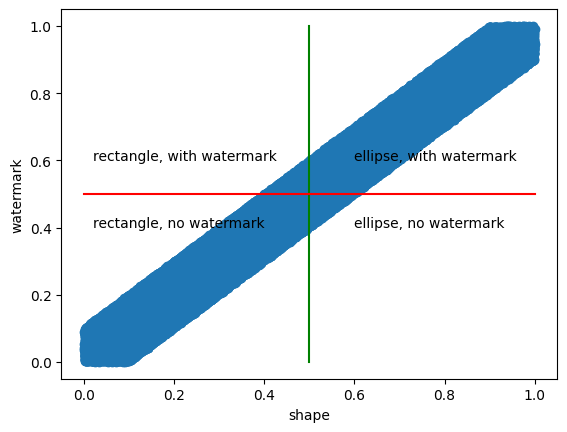

In [3]:

from biased_dsprites_dataset import get_dataset, get_biased_loader
train_ds, train_loader, test_ds, test_loader = get_dataset(0.9, 0.5)
train_ds[0]

In [6]:
with open("ground_truths.json", "r") as f:
    ground_truths = json.load(f)
ground_truths

{'data-0_0-0_5': {'watermark': 0.0,
  'shape': 0.9786096256684492,
  'scale': 0.1475935828877005,
  'orientation': 0.18702865761689288,
  'posX': 0.1535276867345178,
  'posY': 0.12558219768845952},
 'data-0_02-0_5': {'watermark': 0.016042780748663103,
  'shape': 0.9411764705882353,
  'scale': 0.1283422459893048,
  'orientation': 0.20348279171808575,
  'posX': 0.10764188373296535,
  'posY': 0.11799206486113513},
 'data-0_04-0_5': {'watermark': 0.0,
  'shape': 1.0053475935828877,
  'scale': 0.0780748663101604,
  'orientation': 0.167420814479638,
  'posX': 0.06537864412627223,
  'posY': 0.06365361393824397},
 'data-0_06-0_5': {'watermark': 0.0,
  'shape': 0.9625668449197861,
  'scale': 0.07058823529411762,
  'orientation': 0.1894967777320718,
  'posX': 0.053475935828877,
  'posY': 0.06210108676901849},
 'data-0_08-0_5': {'watermark': 0.0,
  'shape': 0.9732620320855615,
  'scale': 0.10695187165775397,
  'orientation': 0.15124091594679823,
  'posX': 0.09418664826634472,
  'posY': 0.07659134

In [7]:
vals = list(
    [{k: f'{np.round(v * 100, 2)}%' for k, v in a.items()} for a in ground_truths.values()]
)
biases = list(from_name(k)[0] for k in ground_truths.keys())
pvals = []
for i in range(0, len(vals)):
    bl = vals[i]
    bl["bias"] = biases[i]
    pvals.append(bl)
with open("vals.json", "w") as f:
    json.dump(pvals, f)

In [8]:
print(len(biases))

51


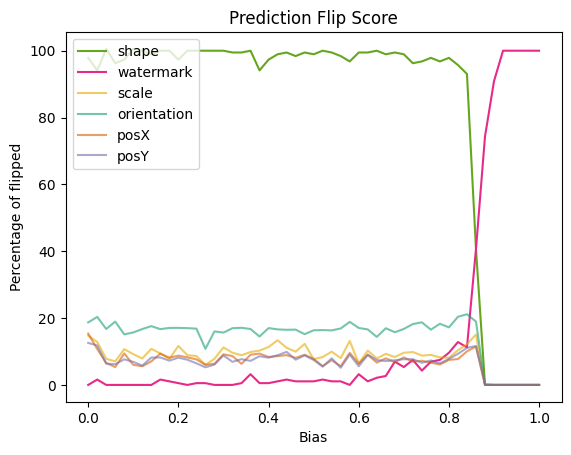

In [26]:
COLORS = ['#e72950','#66a61e','#e6ab0299','#1b9e7799','#d95f0299','#7570b399',]
def plot_pred_flip():
    gt_data = [v for v in ground_truths.values()]
    biases = [from_name(k)[0] for k in ground_truths.keys()]
    keys = list(gt_data[0].keys())
    
    for i in [1,0,2,3,4,5]:
        k = keys[i]
        color = COLORS[i]
        lat_data = [a[k]*100 for a in gt_data]
        plt.plot(biases, lat_data, c=color, label=k)
    plt.legend(loc="upper left")
    plt.ylabel("Percentage of flipped")
    plt.xlabel("Bias")
    plt.title("Prediction Flip Score")
plot_pred_flip()

In [34]:
with open("accuracies_fine.json", "r") as f:
    analysis_data = json.load(f)
analysis_data

{'data-0_8-0_5': {'train_accuracy': [91.93250868055556, 91.87282986111111],
  'all_wm_accuracy': [0.029834553837808517, 99.99728688480113],
  'no_wm_accuracy': [100.0, 0.0],
  'bias': 0.805,
  'strength': 0.5,
  'prediction_flip': {'watermark': 1.0,
   'shape': 0.0,
   'scale': 0.0,
   'orientation': 0.0,
   'posX': 0.0,
   'posY': 0.0},
  'watermark_mask_concepts': {'0': {'0': {'linear_layers.0_0': {'wm': 0.0,
      'rest': 0.0},
     'linear_layers.0_1': {'wm': -0.0004653405921999365,
      'rest': 0.001452445867471397},
     'linear_layers.0_2': {'wm': -0.0006244097021408379,
      'rest': -5.826620326843113e-05},
     'linear_layers.0_3': {'wm': -0.00017293398559559137,
      'rest': -7.0352398324757814e-06},
     'linear_layers.0_4': {'wm': -0.00035499705700203776,
      'rest': 0.0009937402792274952},
     'linear_layers.0_5': {'wm': 0.0, 'rest': 0.0}},
    '1': {'linear_layers.0_0': {'wm': 0.0, 'rest': 0.0},
     'linear_layers.0_1': {'wm': 0.1825641244649887,
      'rest': -0.0

In [35]:
data = sorted(analysis_data.values(), key=lambda x: x["bias"])
biases = [a["bias"] for a in  data]


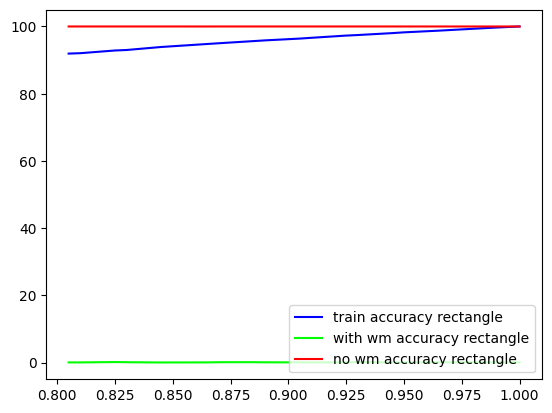

In [37]:

def plot_accs(shape):
    label = "rectangle" if shape == 0 else "ellipse"
    #plt.plot(biases, [a["test_accuracy"][shape] for a in  data], c="#806", label=f"test accuracy {label}")
    plt.plot(biases, [a["train_accuracy"][shape] for a in  data], c="#00f", label=f"train accuracy {label}")
    plt.plot(biases, [a["all_wm_accuracy"][shape] for a in  data], c="#0f0", label=f"with wm accuracy {label}")
    plt.plot(biases, [a["no_wm_accuracy"][shape] for a in  data], c="#f00", label=f"no wm accuracy {label}")
    plt.legend(loc="lower right")
plot_accs(0)

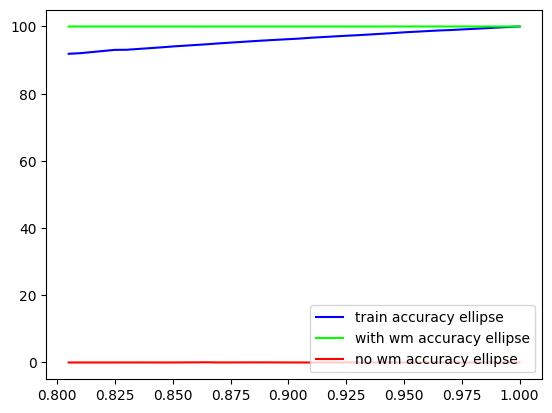

In [38]:
plot_accs(1)

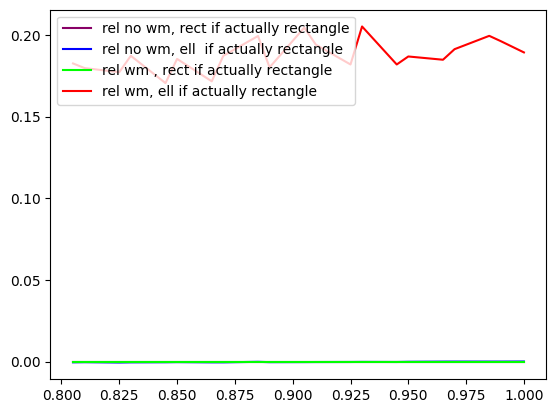

In [40]:
def plot_linear_layer(shape, box="wm"):
    label = "rectangle" if shape == "0" else "ellipse"
    plt.plot(biases, [a["watermark_mask_concepts"][shape]["0"]["linear_layers.0_0"][box] for a in  data], c="#806", label=f"rel no wm, rect if actually {label}")
    plt.plot(biases, [a["watermark_mask_concepts"][shape]["0"]["linear_layers.0_1"][box] for a in  data], c="#00f", label=f"rel no wm, ell  if actually {label}")
    plt.plot(biases, [a["watermark_mask_concepts"][shape]["1"]["linear_layers.0_0"][box] for a in  data], c="#0f0", label=f"rel wm , rect if actually {label}")
    plt.plot(biases, [a["watermark_mask_concepts"][shape]["1"]["linear_layers.0_1"][box] for a in  data], c="#f00", label=f"rel wm, ell if actually {label}")
    plt.legend(loc="upper left")
plot_linear_layer("0", "wm")

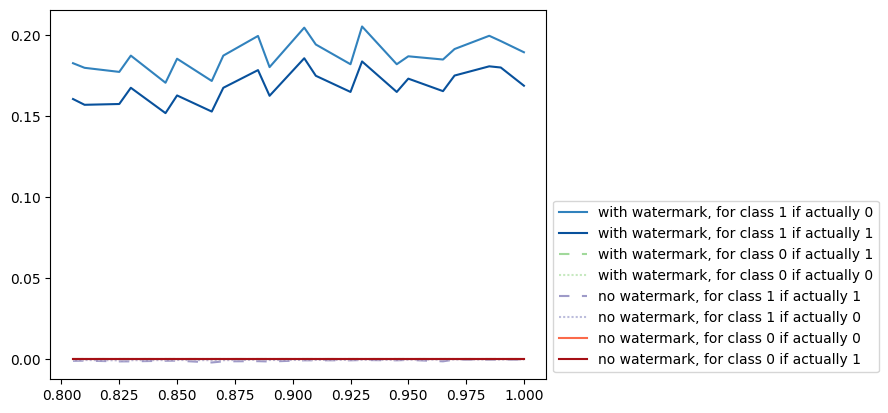

In [41]:
rcol = ["#fb6a4a", "#bcbddc", "#c7e9c0", "#3182bd"]
ecol = ["#a50f15", "#9e9ac8", "#a1d99b", "#08519c"]
box = "wm"
shape = "0"

def plot_one(shape, box, p, col, wm):
    wm_lab = "with" if wm else "no"
    pat= (0, (5, 6)) if wm != p else "solid"
    pat= (0, (1, 1)) if wm != p and shape == 0 else pat
    plt.plot(
        biases,
        [a["watermark_mask_concepts"][str(shape)][str(wm)][f"linear_layers.0_{p}"][box] for a in data],
        c=col,
        linestyle=pat,
        label=f"{wm_lab} watermark, for class {p} if actually {shape}",
    )
plot_one(0, box, 1, rcol[3], 1)
plot_one(1, box, 1, ecol[3], 1)
plot_one(1, box, 0, ecol[2], 1)
plot_one(0, box, 0, rcol[2], 1)
plot_one(1, box, 1, ecol[1], 0)
plot_one(0, box, 1, rcol[1], 0)
plot_one(0, box, 0, rcol[0], 0)
plot_one(1, box, 0, ecol[0], 0)

plt.legend(loc="lower left", bbox_to_anchor=(1, 0))

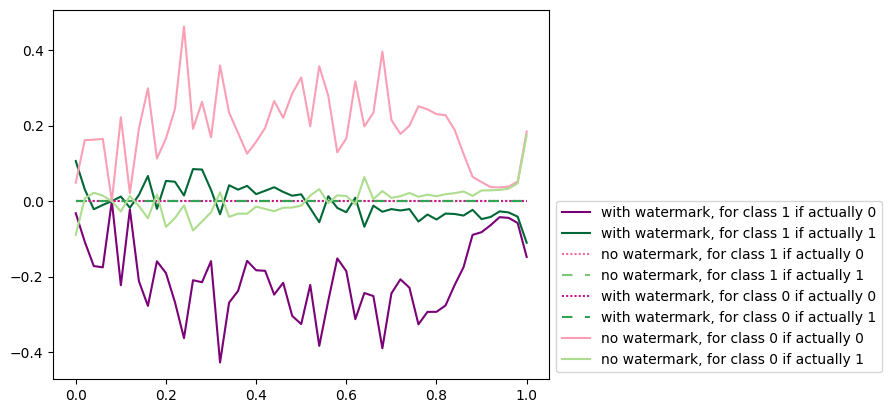

In [54]:
box = "rest"
plot_one(0, box, 1, rcol[3], 1)
plot_one(1, box, 1, ecol[3], 1)
plot_one(0, box, 1, rcol[1], 0)
plot_one(1, box, 1, ecol[1], 0)
plot_one(0, box, 0, rcol[2], 1)
plot_one(1, box, 0, ecol[2], 1)
plot_one(0, box, 0, rcol[0], 0)
plot_one(1, box, 0, ecol[0], 0)

plt.legend(loc="lower left", bbox_to_anchor=(1, 0))

Text(0.5, 0, 'Bias')

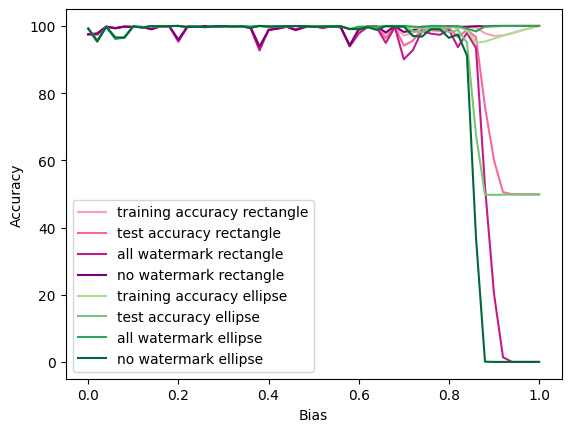

In [72]:
rcol = ['#fa9fb5','#f768a1','#c51b8a','#7a0177']
ecol= ['#addd8e','#78c679','#31a354','#006837']
plt.plot(biases, [a["train_accuracy"][0] for a in  data], c=rcol[0], label=f"training accuracy rectangle")
plt.plot(biases, [a["test_accuracy"][0] for a in  data], c=rcol[1], label=f"test accuracy rectangle")
plt.plot(biases, [a["all_wm_accuracy"][0] for a in  data], c=rcol[2], label=f"all watermark rectangle")
plt.plot(biases, [a["no_wm_accuracy"][0] for a in  data], c=rcol[3], label=f"no watermark rectangle")
plt.plot(biases, [a["train_accuracy"][1] for a in  data], c=ecol[0], label=f"training accuracy ellipse")
plt.plot(biases, [a["test_accuracy"][1] for a in  data], c=ecol[1], label=f"test accuracy ellipse")
plt.plot(biases, [a["all_wm_accuracy"][1] for a in  data], c=ecol[2], label=f"all watermark ellipse")
plt.plot(biases, [a["no_wm_accuracy"][1] for a in  data], c=ecol[3], label=f"no watermark ellipse")
plt.legend(loc="lower left")
plt.ylabel("Accuracy")
plt.xlabel("Bias")

In [71]:
bad = []
for a in  data:
    if a["train_accuracy"][0] > 90 or a["train_accuracy"][1] > 90:
        #print(a["bias"])
        bad.append(a["bias"])

In [12]:
np.round(np.linspace(0.008, 0.017, 10), 3)

[0.001, 0.008, 0.01, 0.016]

array([0.008, 0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016,
       0.017])

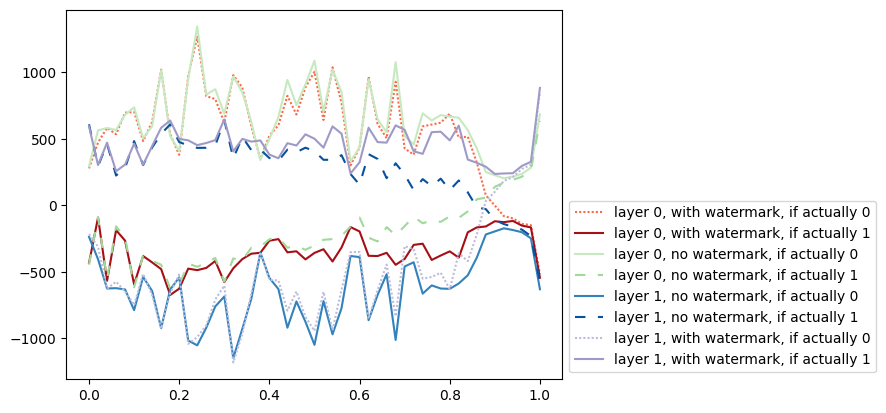

In [82]:
rcol = ["#fb6a4a", "#bcbddc", "#c7e9c0", "#3182bd"]
ecol = ["#a50f15", "#9e9ac8", "#a1d99b", "#08519c"]


def plot_one(shape, wm, l, col):
    wm_lab = "with" if wm else "no"
    pat = (0, (5, 6)) if wm != shape else "solid"
    pat = (0, (1, 1)) if wm != shape and shape == 0 else pat
    plt.plot(
        biases,
        [
            a["watermark_concepts"][f"linear_layers.2"][str(l)][str(shape)][str(wm)]
            for a in data
        ],
        c=col,
        linestyle=pat,
        label=f"layer {l}, {wm_lab} watermark, if actually {shape}",
    )


plot_one(0, 1, 0, rcol[0])
plot_one(1, 1, 0, ecol[0])
plot_one(0, 0, 0, rcol[2])
plot_one(1, 0, 0, ecol[2])
plot_one(0, 0, 1, rcol[3])
plot_one(1, 0, 1, ecol[3])
plot_one(0, 1, 1, rcol[1])
plot_one(1, 1, 1, ecol[1])

plt.legend(loc="lower left", bbox_to_anchor=(1, 0))